In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:

df = pd.read_excel('PVC_BRL.xlsx', sheet_name='PVC_BRL', index_col=[0], parse_dates=[0])

#Fornece um resumo abrangente com: contagem, média, desvio padrão, quartis, mínimo, máximo
df.describe()


,PVC BRL/tonne
count,1165.000000
mean,4118.889815
std,2203.995891
min,1714.433000
25%,2618.143000
50%,3589.643000
75%,4854.746000
max,13818.727000


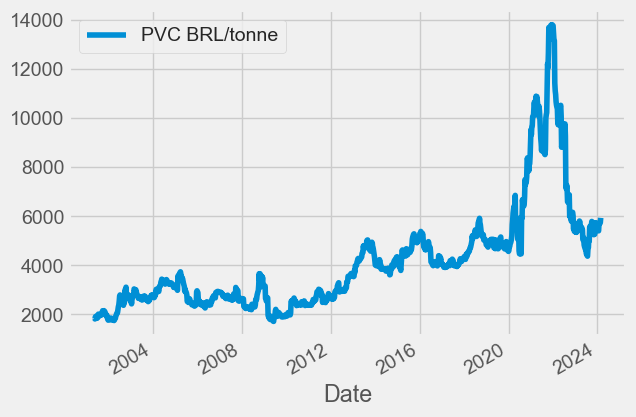

In [52]:
#Agrupa os dados por uma ou mais colunas e aplica funções agregadas.
#Útil para comparar preços por mês, ano, etc.

df_ano = df.groupby('Date').agg({'PVC BRL/tonne': 'mean'})
df_ano.plot()


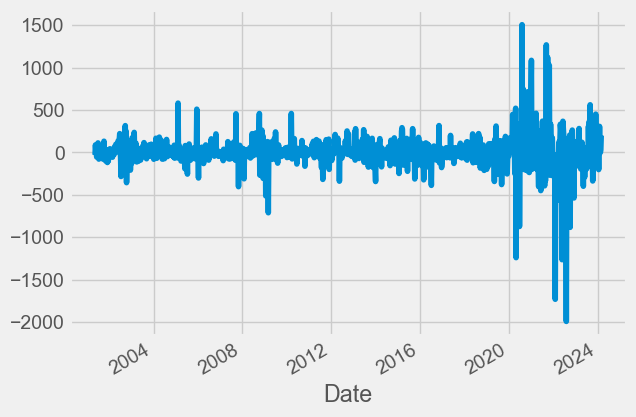

In [53]:
#Calcula a diferença entre valores consecutivos.
#Útil para analisar a mudança nos preços do PVC ao longo do tempo.

df['Diferença'] = df['PVC BRL/tonne'].diff()
df['Diferença'].plot()


## Decomposição Sazonal da Série Temporal:
Em análise de séries temporais, podemos nos deparar com os seguintes elementos:
- Tendência: A direção geral dos dados ao longo do tempo, indicando se a série está aumentando, diminuindo ou mantendo-se estável.
- Sazonalidade: Variações periódicas ou sazonais que ocorrem em intervalos regulares de tempo, como padrões que se repetem anualmente, mensalmente ou semanalmente.
- Ciclo: Flutuações não sazonais repetitivas que geralmente são de longo prazo e não têm um padrão fixo, podendo ser influenciadas por fatores econômicos, políticos ou sociais.
- Resíduo:  A parte da série temporal que não é explicada pela tendência, sazonalidade ou ciclo, representando as variações aleatórias ou não sistemáticas dos dados.

Utilizaremos ferramentas da linguagem Python para decompor a série nos quatro componentes acima, no que chamamos de modelo aditivo:
$$ y(t) = T(t) + S(t) + C(t) + E(t) $$
Em que:
- y representa a série:
- T é o componente de tendência
- S é o componente de sazonalidade
- C é o componente dos ciclos
- E representa os resíduos.

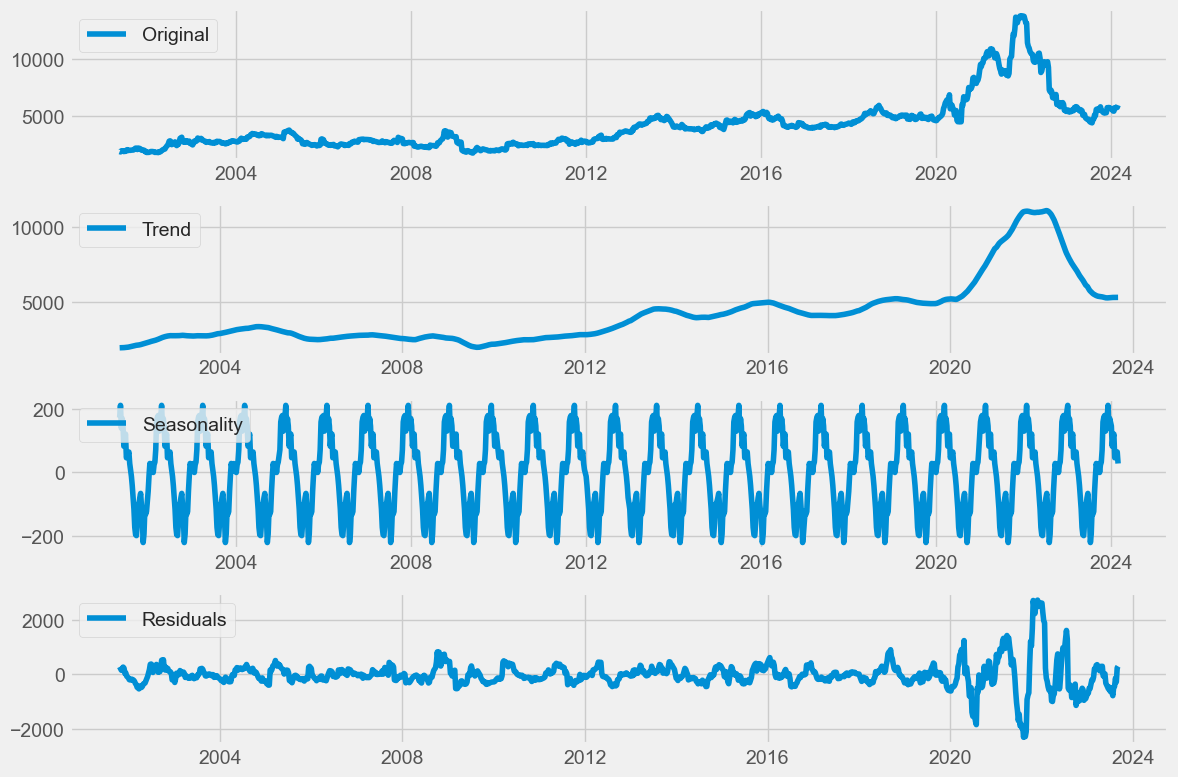

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['PVC BRL/tonne'], model='additive', period=48)

# plotting results
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['PVC BRL/tonne'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Data

In [55]:
# Load data
pvc = pd.read_excel('PVC_BRL.xlsx', sheet_name='PVC_BRL', index_col=[0], parse_dates=[0])
pvc = pvc[pvc.index <= '2019-12-31']
pvc.head()

,PVC BRL/tonne
Date,
2001-05-07,1842.534
2001-05-14,1813.952
2001-05-21,1902.516
2001-05-28,1922.032
2001-06-04,1899.295


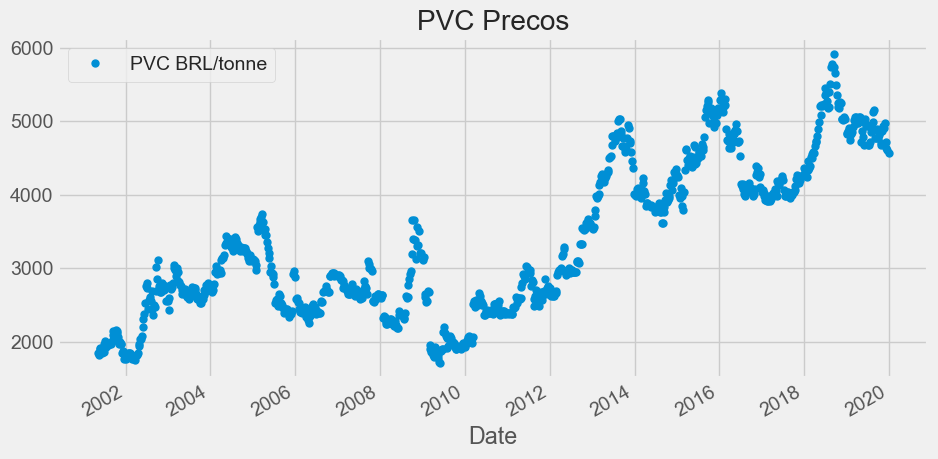

In [56]:
color_pal = sns.color_palette()
pvc.plot(style='.',
          figsize=(10, 5),
          ms=10,
          color=color_pal[0],
          title='PVC Precos')
plt.show()

In [57]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pvc, label='PVC BRL/tonne')
features_and_target = pd.concat([X, y], axis=1)


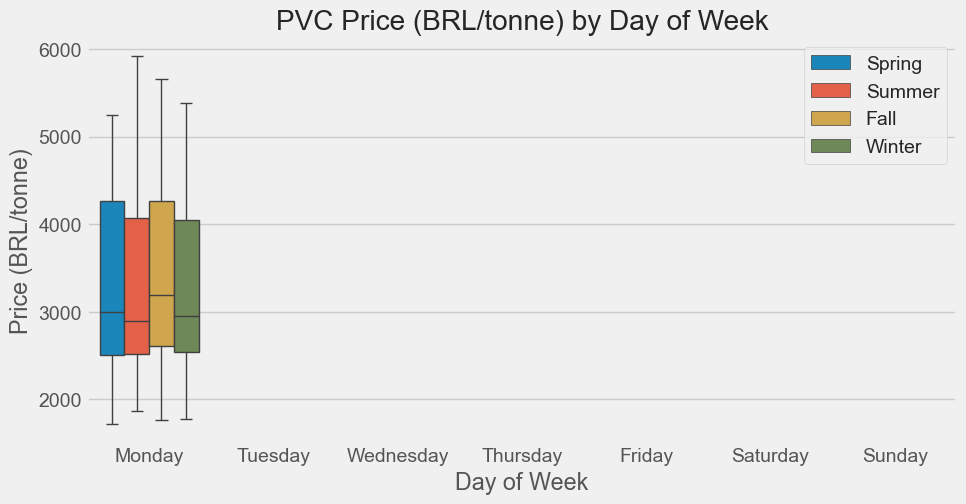

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',  # Assuming your weekday column is named 'weekday'
            y='PVC BRL/tonne',  # Replace with your actual price column name
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('PVC Price (BRL/tonne) by Day of Week')  # Adjust title as needed
ax.set_xlabel('Day of Week')
ax.set_ylabel('Price (BRL/tonne)')  # Adjust y-axis label
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

Train / Test Split¶


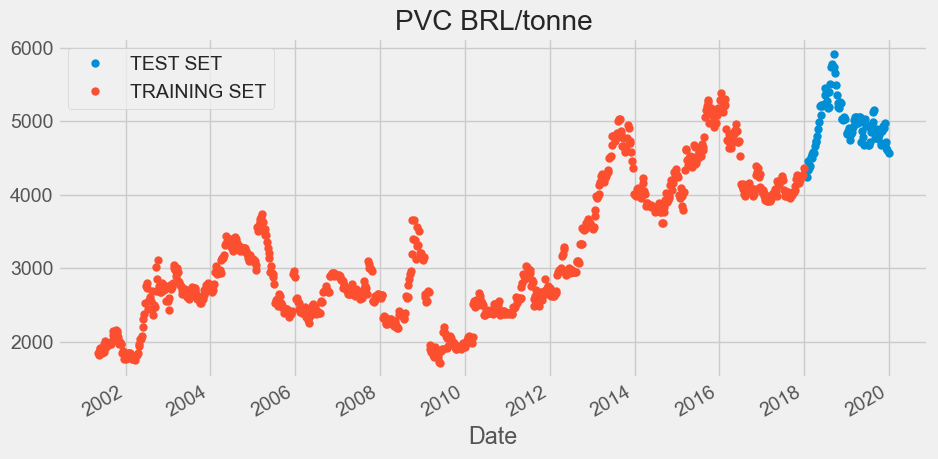

In [59]:
split_date = '2018-01-01'

pvc_train = pvc.loc[pvc.index <= split_date].copy()
pvc_test = pvc.loc[pvc.index > split_date].copy()

pvc_test \
    .rename(columns={'PVC BRL/tonne': 'TEST SET'}) \
    .join(pvc_train.rename(columns={'PVC BRL/tonne': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PVC BRL/tonne', style='.', ms=10)
plt.show()


## Simple Prophet Model¶
Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
Datetime column named: ds
target : y

In [60]:
# Format data for prophet model using ds and y
pvc_train_prophet = pvc_train.reset_index() \
    .rename(columns={'Date':'ds',
                     'PVC BRL/tonne':'y'})

In [61]:
%%time
# is this right? becacause tha data has yealy seasonality
model = Prophet(yearly_seasonality=True,
                seasonality_mode='multiplicative')
model.fit(pvc_train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: total: 422 ms
Wall time: 1.38 s


In [62]:
# Predict on test set with model
pvc_test_prophet = pvc_test.reset_index() \
    .rename(columns={'Date':'ds',
                     'PVC BRL/tonne':'y'})

pvc_test_fcst = model.predict(pvc_test_prophet)

In [63]:
pvc_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2018-01-08,4335.714974,3869.734565,4781.198409,4335.714974,4335.714974,-0.006281,-0.006281,-0.006281,-0.006281,-0.006281,-0.006281,0.0,0.0,0.0,4308.484162
1,2018-01-15,4335.698798,3831.444095,4725.105247,4335.698798,4335.698798,-0.012520,-0.012520,-0.012520,-0.012520,-0.012520,-0.012520,0.0,0.0,0.0,4281.414649
2,2018-01-22,4335.682623,3816.893740,4697.842937,4335.682623,4335.682623,-0.015255,-0.015255,-0.015255,-0.015255,-0.015255,-0.015255,0.0,0.0,0.0,4269.542145
3,2018-01-29,4335.666447,3827.704722,4707.317742,4335.666447,4335.666447,-0.014319,-0.014319,-0.014319,-0.014319,-0.014319,-0.014319,0.0,0.0,0.0,4273.582032
4,2018-02-05,4335.650272,3801.834669,4775.185180,4335.650272,4335.650272,-0.012572,-0.012572,-0.012572,-0.012572,-0.012572,-0.012572,0.0,0.0,0.0,4281.142774


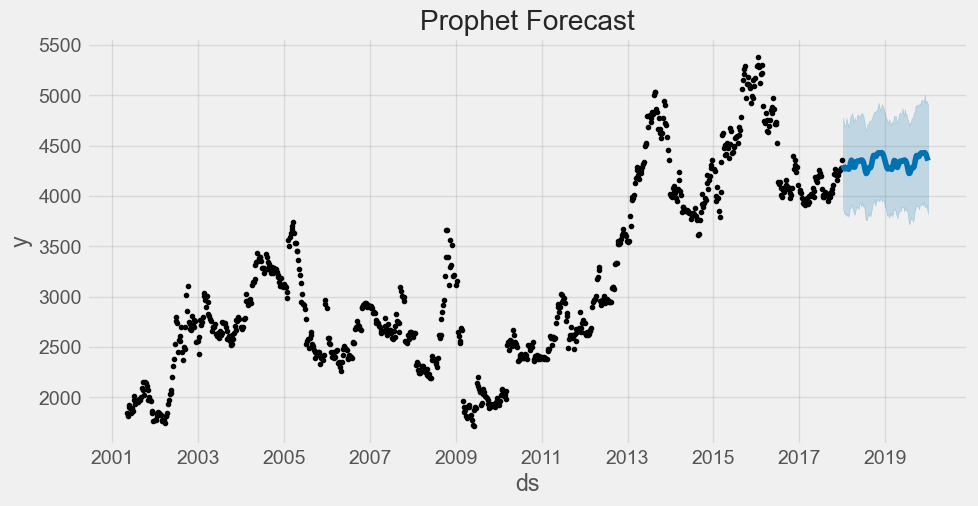

In [64]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pvc_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

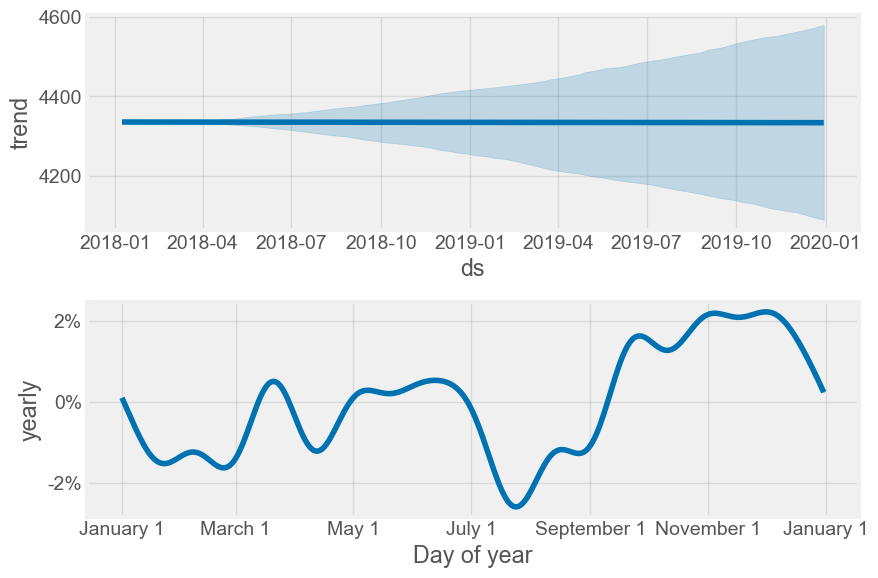

In [65]:
fig = model.plot_components(pvc_test_fcst)
plt.show()

Compare Forecast to Actuals¶


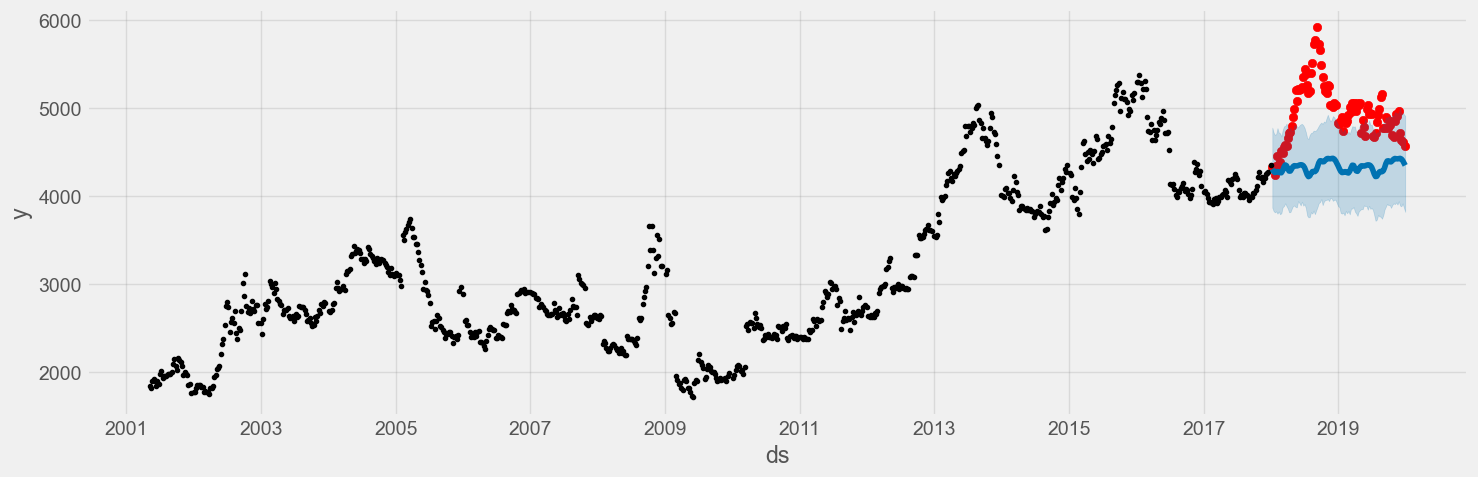

In [66]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pvc_test.index, pvc_test['PVC BRL/tonne'], color='r')
fig = model.plot(pvc_test_fcst, ax=ax)

ConversionError: Failed to convert value(s) to axis units: '2018-01-001'

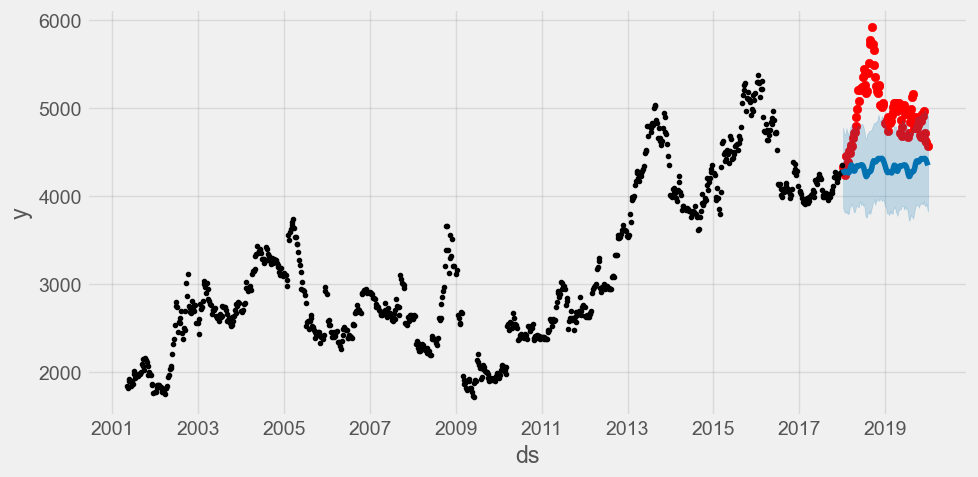

In [67]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pvc_test.index, pvc_test['PVC BRL/tonne'], color='r')
fig = model.plot(pvc_test_fcst, ax=ax)
ax.set_xbound(lower='2018-01-001',
              upper='2019-12-31')
ax.set_ylim(0, 60000)
plot = plt.suptitle('Forecast vs Actuals')

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pvc_test.index, pvc_test['PVC BRL/tonne'], color='r')
fig = model.plot(pvc_test_fcst, ax=ax)
ax.set_xbound(lower='2018-01-06', upper='2019-12-31')
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()